# Clustering

make:
- load reefclr csvs into an object + imnet into another
- make side by side umap plots of each
- make pca as more precise?
- do chi-sq, plot table

notes 
- for aus and fp this should work
- for individual sounds it still should, it will 

Specify which embeddings to use

In [2]:
# Specify a list of categories you want to include
enabled_categories = ['ReefCLR', 'ImageNet', 'VGGish']  # Add or remove categories here

# Specify path to the embedding cvs's
csv_directory = '/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/evaluation/embeddings/raw_embeddings'

In [3]:
import pandas as pd
import umap
from sklearn.cluster import AffinityPropagation
from scipy import stats

/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ben/miniconda3/envs/simclr_pytorch_reefs/l

Make a dictionary of all embeddings dataframes

In [14]:
# Initialize an empty dictionary
datasets = {}

# List all CSV files in the directory
all_csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

# alphabetise
all_csv_files.sort()

# Loop through each file and load it into the appropriate dictionary
for csv_file in all_csv_files:

    # Create the full path to the CSV file
    full_path = os.path.join(csv_directory, csv_file)

    # Determine the type and location name from the file name
    file_type, location = csv_file.split('_', 1)
    location = location.rsplit('_', 1)[0]  # Remove the "_embeddings.csv" part

    # Skip categories not in the enabled list
    if file_type not in enabled_categories:
        continue

    # Read the CSV file into a DataFrame
    df = pd.read_csv(full_path)
    
    # Add the DataFrame to the appropriate dictionary
    if file_type not in datasets:
        datasets[file_type] = {}
    datasets[file_type][location] = df

# Check dict was created correctly
for category, locations in datasets.items():
    print(f"Category: {category}")
    print(f"Locations: {list(locations.keys())}\n")

Category: ImageNet
Locations: ['australia', 'bermuda', 'florida', 'french_polynesia', 'indonesia', 'kenya']

Category: ReefCLR
Locations: ['australia', 'bermuda', 'florida', 'french_polynesia', 'indonesia', 'kenya']



In [ ]:
specific_df = datasets['ReefCLR']['australia']['VGGish']
print(specific_df.head())

In [22]:
# Initialize a results DataFrame to store the chi2 statistics and p-values
results = pd.DataFrame(columns=['Category', 'Location', 'Num_Clusters', 'Chi2_Stat', 'P_Value'])

# Loop through each category and its datasets
for category, locations in datasets.items():
    for location, df in locations.items():
        # Extract the features from the DataFrame
        features = df.loc[:, 'Feature_1':]  # Adjust this based on your DataFrame structure
        labels = df['Label']

        # UMAP dimensionality reduction. Number of dimensions is set by n_components.
        umap_embedding = umap.UMAP(
            n_neighbors=50,
            n_components=10,
            min_dist=0,
            random_state=0,
        ).fit_transform(features)

        # Affinity Propagation clustering
        af = AffinityPropagation(random_state=0, damping=0.9)
        clustering = af.fit(umap_embedding)
        num_clusters = len(clustering.cluster_centers_indices_)

        # Create contingency table
        class_type = labels.to_numpy()
        cluster_labels = clustering.labels_
        contingency_table = pd.crosstab(cluster_labels, class_type)

        # Chi-square test
        chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)

        # Save results in DataFrame
        new_row = pd.DataFrame({'Category': [category], 
                                'Location': [location], 
                                'Num_Clusters': [num_clusters], 
                                'Chi2_Stat': [chi2_stat], 
                                'P_Value': [p_value]})
        results = pd.concat([results, new_row], ignore_index=True)

# order the results hdfere, so we get each location next to each other

# Save the results to a CSV file
#results.to_csv('analysis_results.csv', index=False)


In [25]:
# order results so by location
results = results.sort_values(by=['Location', 'Category'])
results

,Category,Location,Num_Clusters,Chi2_Stat,P_Value
0,ImageNet,australia,64,516.445082,2.032088e-72
6,ReefCLR,australia,61,254.241849,9.528436e-26
1,ImageNet,bermuda,10,789.055342,3.808284e-131
7,ReefCLR,bermuda,8,1307.879670,8.622588e-247
2,ImageNet,florida,53,2823.698835,0.000000e+00
8,ReefCLR,florida,48,2647.520080,0.000000e+00
3,ImageNet,french_polynesia,24,5760.581385,0.000000e+00
9,ReefCLR,french_polynesia,31,5820.833945,0.000000e+00
4,ImageNet,indonesia,35,1453.347837,7.585708e-284
10,ReefCLR,indonesia,38,1459.273108,1.153653e-282


# Visualise UMAPS

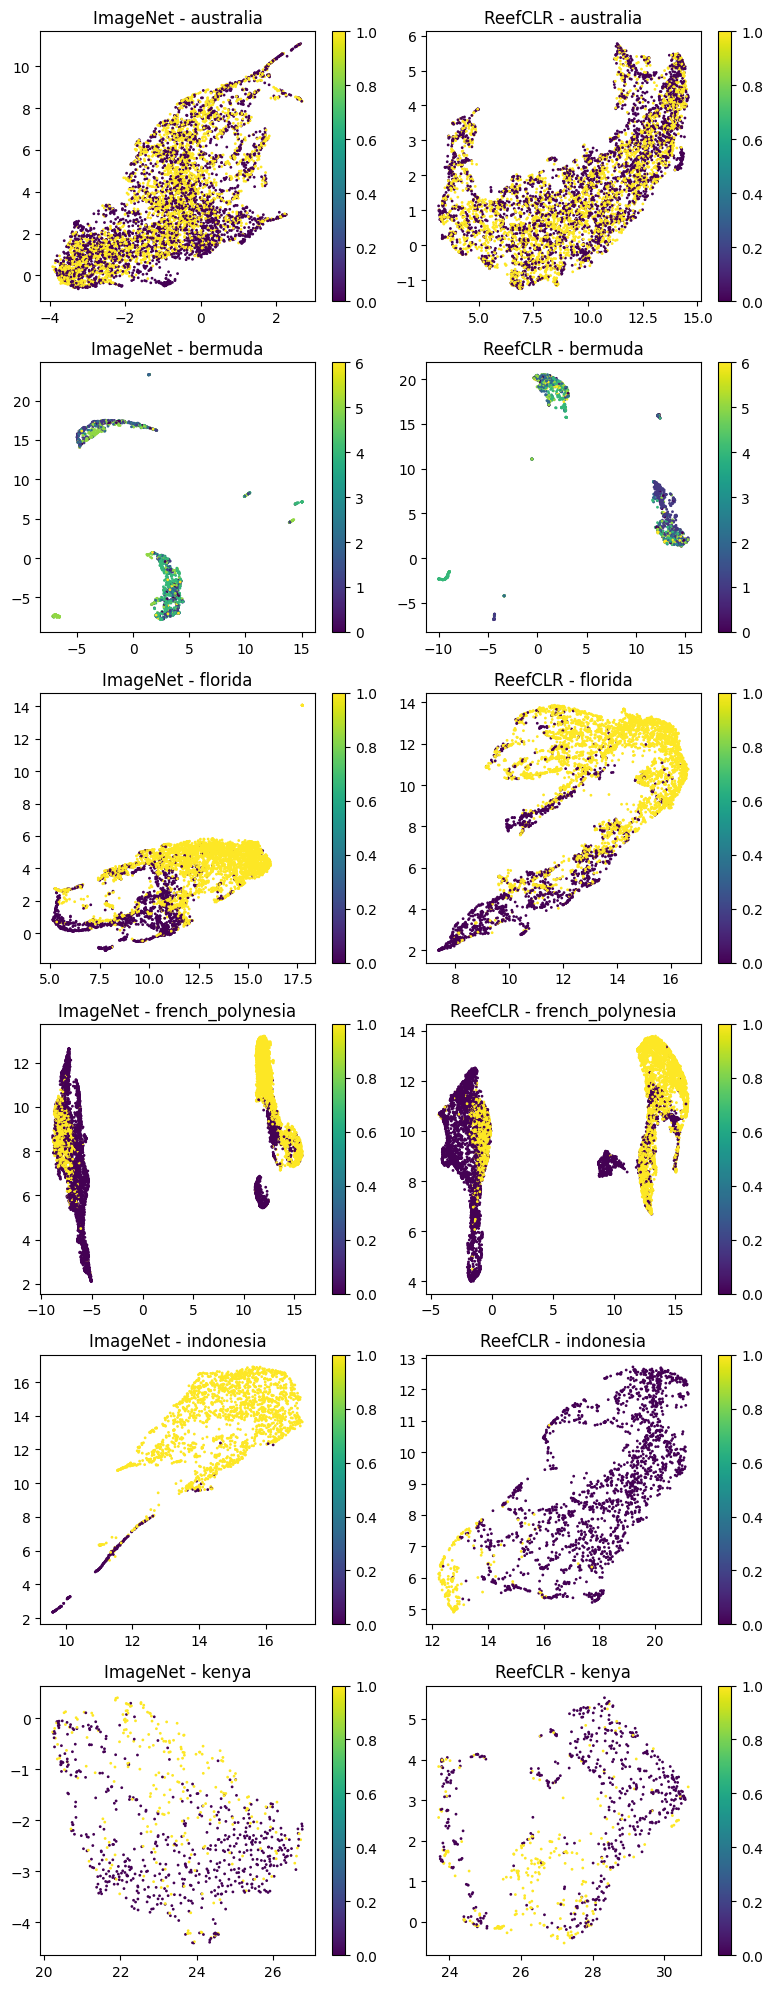

In [38]:
import matplotlib.pyplot as plt
import umap
import numpy as np
import pandas as pd

# Count the total number of unique locations and categories
total_locations = sum(len(locations) for locations in datasets.values())
total_categories = len(datasets)

# Initialize the plot grid
fig, axes = plt.subplots(len(datasets[list(datasets.keys())[0]]), total_categories, figsize=(8, 30))


# Ensure axes is always 2D
if total_locations == 1 and total_categories == 1:
    axes = np.array([[axes]])

# Loop through each category and each location to fill in the plots
for col_idx, (category, locations) in enumerate(datasets.items()):
    for row_idx, (location, df) in enumerate(locations.items()):
        ax = axes[row_idx, col_idx]

        # Perform UMAP dimensionality reduction
        features = df.loc[:, 'Feature_1':]
        embedding = umap.UMAP(
            n_neighbors=30,
            min_dist=0,
            n_components=2,
            random_state=42,
        ).fit_transform(features)

        # Create the scatter plot
        scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=df['Label'], s=1)
        plt.colorbar(scatter, ax=ax)

        ax.set_title(f'{category} - {location}')

plt.tight_layout()
plt.show()

# FIX - legend is currently incorect, shows a scale bar when it should show class labels